<a href="https://colab.research.google.com/github/asadali163/Time-Series-Experiments/blob/main/codebase/Airline_(ML)_Stationary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O airline.csv https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-07-15 18:24:01--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline.csv’

airline.csv         100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-07-15 18:24:01 (27.7 MB/s) - ‘airline.csv’ saved [2036/2036]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [ ]:
df = pd.read_csv('airline.csv', index_col='Month', parse_dates= True)
df.index.freq = 'MS'
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
df['LogPassengers'] = np.log(df['Passengers'])
df['DiffLogPassengers'] = df['LogPassengers'].diff()
df.head()

,Passengers,LogPassengers,DiffLogPassengers
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


In [ ]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [ ]:
series = df['DiffLogPassengers'][1:]
print(df.shape, series.shape)

(144, 3) (143,)


In [ ]:
# Let use the lag value of T = 10
T = 10
X, Y = [], []
for t in range(len(series) - T):
  x = series.iloc[t:t+T]
  X.append(x)
  y = series.iloc[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
print(X.shape, Y.shape)

(133, 10) (133,)


In [ ]:
X_train, Y_train = X[:-N_test], Y[:-N_test]
X_test, Y_test = X[-N_test:], Y[-N_test:]

In [ ]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr.score(X_train, Y_train)

0.6837135048453121

In [ ]:
lr.score(X_test, Y_test)

0.6492870172668167

In [ ]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [ ]:
train_idx[:T+1] = False

In [ ]:
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers'].copy()

In [ ]:
last_train = train.iloc[-1]['LogPassengers']

In [ ]:
# 1 step forecast
df.loc[train_idx, 'LR_1step_forecast_train'] = prev[train_idx] + lr.predict(X_train)
df.loc[test_idx, 'LR_1step_forecast_test'] = prev[test_idx] + lr.predict(X_test)

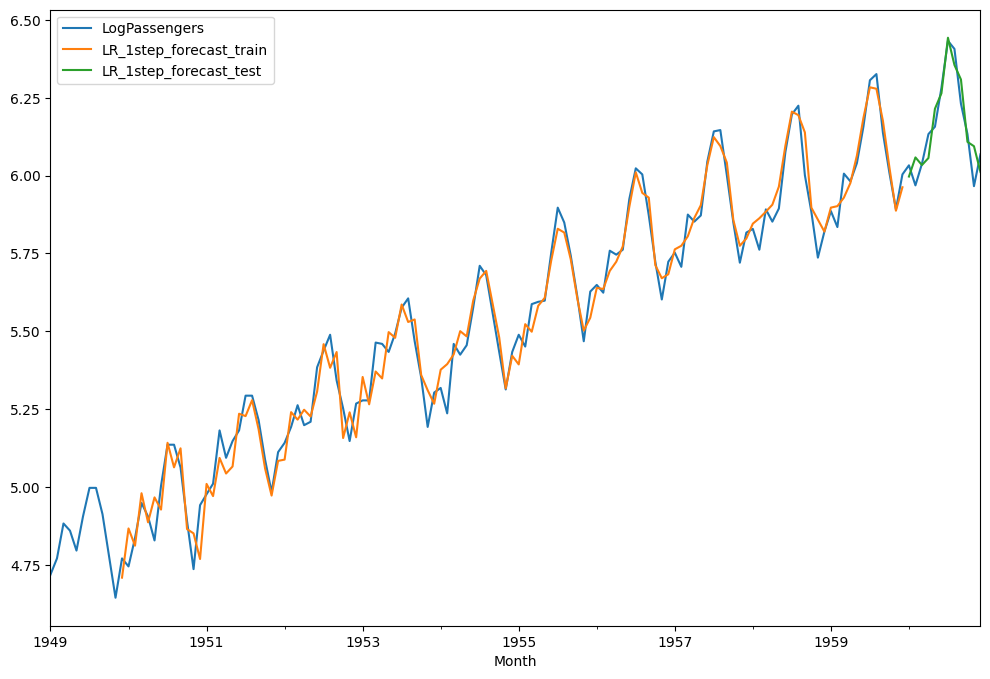

In [ ]:
# Plot 1-step forecast
df[['LogPassengers', 'LR_1step_forecast_train', 'LR_1step_forecast_test']].plot(figsize=(12, 8))
plt.show();

As we can see the prediction is good as compare to the results without differencing

### Let's do Multi-step forecast with differencing

In [ ]:
multistep_predictions = []

last_x = X_test[0]

while len(multistep_predictions) < N_test:
  p = lr.predict(last_x.reshape(1, -1))[0]
  multistep_predictions.append(p)
  # print("Last X is: ", last_x)
  last_x = np.roll(last_x, -1)
  last_x[-1] = p


In [ ]:
df.loc[test_idx, 'LR_multistep_forecast_test'] = last_train + np.cumsum(multistep_predictions)

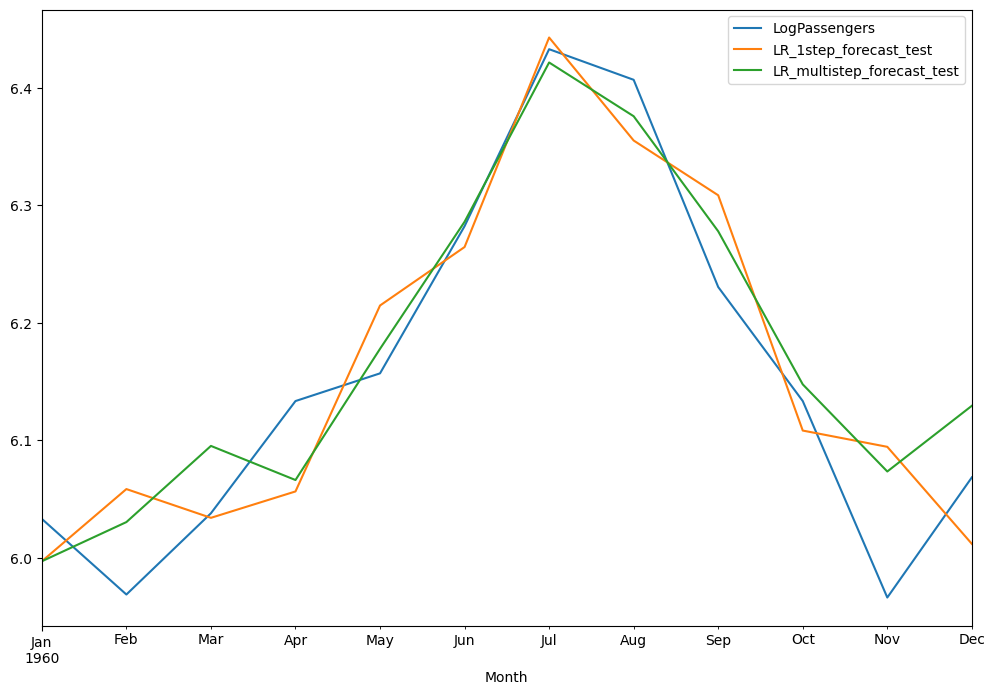

In [ ]:
# Plot now
df[['LogPassengers', 'LR_1step_forecast_test', 'LR_multistep_forecast_test']][-12:].plot(figsize=(12, 8))
plt.show();

### Now work or multi step multi output forecasat

In [ ]:
Tx = T
Ty = N_test
X, Y = [], []

for t in range(len(series) - Tx - N_test + 1):
  x = series.iloc[t:t+T]
  X.append(x)
  y = series.iloc[t+T:t+T+N_test]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
print(X.shape, Y.shape)

(122, 10) (122, 12)


In [ ]:
X_train_m, Y_train_m = X[:-1], Y[:-1]
X_test_m, Y_test_m = X[-1:], Y[-1:]
print(X_train_m.shape, Y_train_m.shape, X_test_m.shape, Y_test_m.shape)

(121, 10) (121, 12) (1, 10) (1, 12)


In [ ]:
lr_m = LinearRegression()
lr_m.fit(X_train_m, Y_train_m)
lr_m.score(X_train_m, Y_train_m)

0.8141637147930584

In [ ]:
r2_score(Y_test_m.flatten(), lr_m.predict(X_test_m).flatten())

0.7867137438847718

In [ ]:
lr_m.predict(X_test_m).flatten()

array([-0.00687509, -0.01949089,  0.14435477, -0.00799858,  0.06216696,
        0.12218403,  0.1333204 ,  0.02038648, -0.17426486, -0.1409949 ,
       -0.10930461,  0.08435559])

In [ ]:
df.loc[test_idx, 'Multioutput_forecast'] = last_train + np.cumsum(lr_m.predict(X_test_m).flatten())

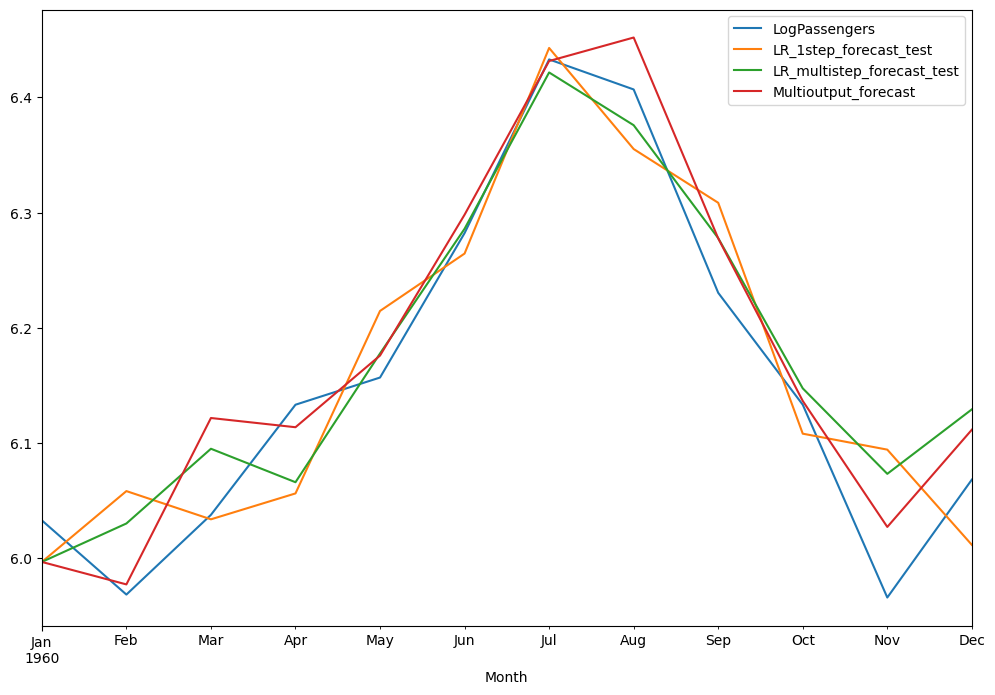

In [ ]:
# Plot all results
df[['LogPassengers', 'LR_1step_forecast_test', 'LR_multistep_forecast_test', 'Multioutput_forecast']][-12:].plot(figsize=(12, 8))
plt.show();

In [ ]:
# Let's calculate the Mean Square Percentage Error
mape_lr_1step = mean_absolute_percentage_error(df.iloc[test_idx][-N_test:]['LogPassengers'], df.loc[test_idx, 'LR_1step_forecast_test'])
mape_lr_multistep = mean_absolute_percentage_error(df.iloc[test_idx][-N_test:]['LogPassengers'], df.loc[test_idx, 'LR_multistep_forecast_test'])
mape_multioutput = mean_absolute_percentage_error(df.iloc[test_idx][-N_test:]['LogPassengers'], df.loc[test_idx, 'Multioutput_forecast'])
print(f"MAPE for 1-step forecast: {mape_lr_1step}")
print(f"MAPE for multi-step forecast: {mape_lr_multistep}")
print(f"MAPE for multi-output forecast: {mape_multioutput}")


MAPE for 1-step forecast: 0.008623613141312235
MAPE for multi-step forecast: 0.007109281288502536
MAPE for multi-output forecast: 0.005245261617574879


So from mape, we can see that the multi-output forecast is the best

# Test Other Models

In [ ]:
def one_step_and_multistep_forecast(model, name):
  model.fit(X_train, Y_train)
  df.loc[test_idx, f'{name}_1step_forecast_test'] = prev[test_idx] + model.predict(X_test)
  df.loc[train_idx, f'{name}_1step_forecast_train'] = prev[train_idx] + model.predict(X_train)

  multistep_predictions = []

  last_x = X_test[0]
  while len(multistep_predictions) < N_test:
    p = model.predict(last_x.reshape(1, -1))[0]
    multistep_predictions.append(p)
    # print("Last X is: ", last_x)
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  df.loc[test_idx, f'{name}_multistep_forecast_test'] = last_train + np.cumsum(multistep_predictions)
  # df.loc[train_idx, f'{name}_multistep_forecast_train'] = last_train + np.cumsum(model.predict(X_train).flatten())

  # MAPE of multistep
  mape = mean_absolute_percentage_error(df.iloc[test_idx][-N_test:]['LogPassengers'], df.loc[test_idx, f'{name}_multistep_forecast_test'])
  print(f"MAPE for {name} multi-step forecast: {mape}")

  # Print
  df[[f'LogPassengers', f'{name}_1step_forecast_test', f'{name}_multistep_forecast_test']][-12:].plot(figsize=(12, 8))
  plt.show();

MAPE for SVR multi-step forecast: 0.012149122102392764


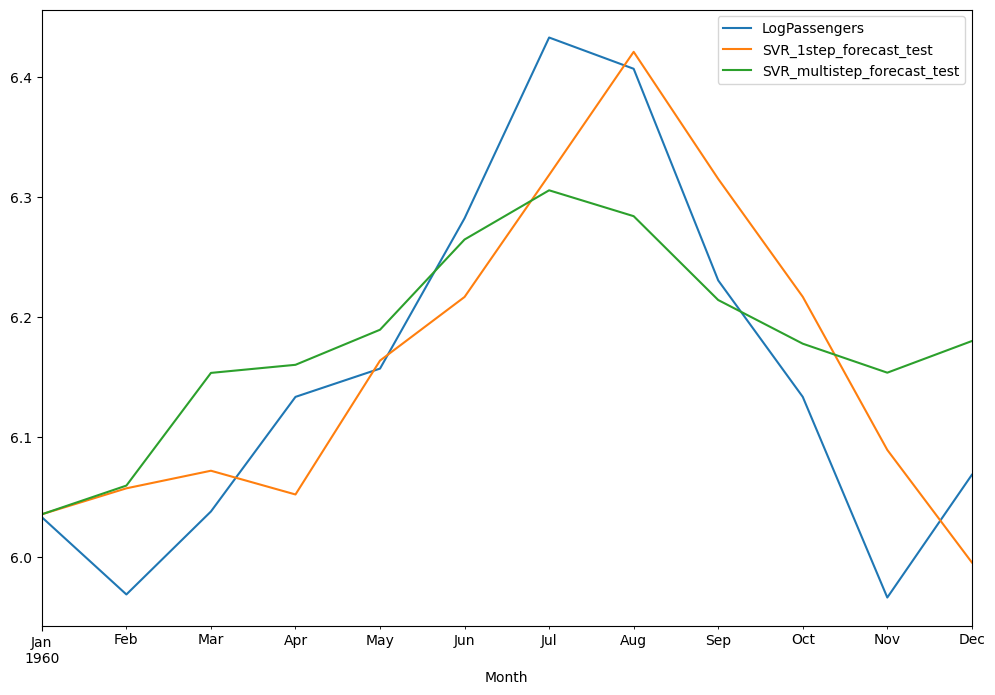

In [ ]:
one_step_and_multistep_forecast(SVR(), 'SVR')

MAPE for RandomForest multi-step forecast: 0.005766943991987166


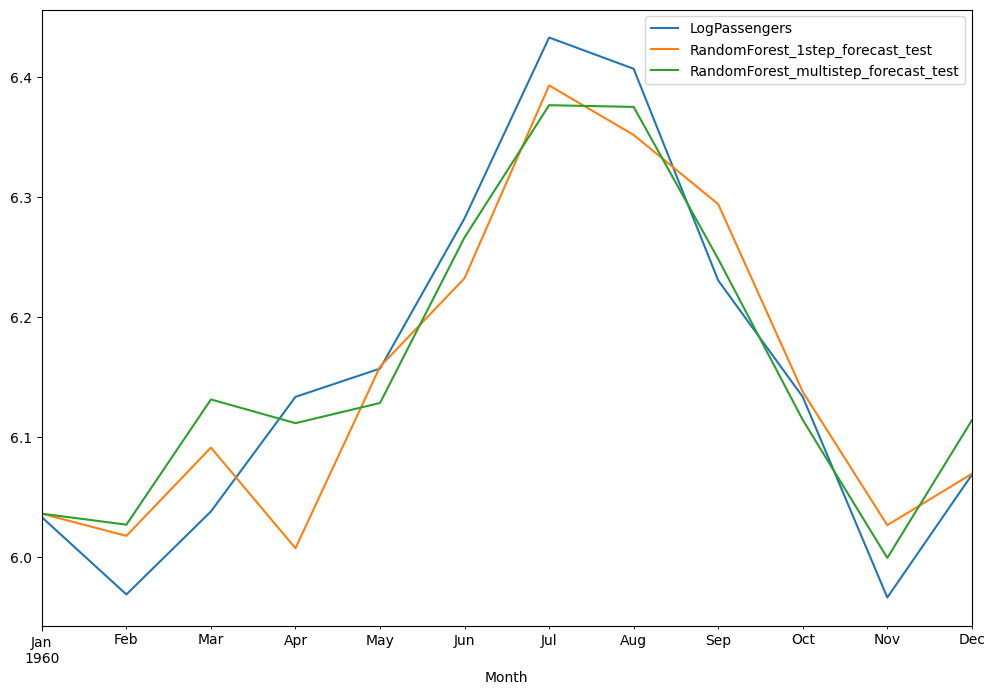

In [ ]:
# Let's try Random forest
one_step_and_multistep_forecast(RandomForestRegressor(), 'RandomForest')

In [ ]:
# Let's have a method for multi-output forecast
def multioutput_forecast(model, name):
  model.fit(X_train_m, Y_train_m)
  df.loc[test_idx, f'{name}_multioutput_forecast'] = last_train + np.cumsum(model.predict(X_test_m).flatten())

  # MAPE of multistep
  mape = mean_absolute_percentage_error(df.iloc[test_idx][-N_test:]['LogPassengers'], df.loc[test_idx, f'{name}_multioutput_forecast'])
  print(f"MAPE for {name} multi-output forecast: {mape}")

  # Print
  df[[f'LogPassengers', f'{name}_multioutput_forecast']][-12:].plot(figsize=(12, 8))
  plt.show();

MAPE for RandomForest multi-output forecast: 0.004592236656591842


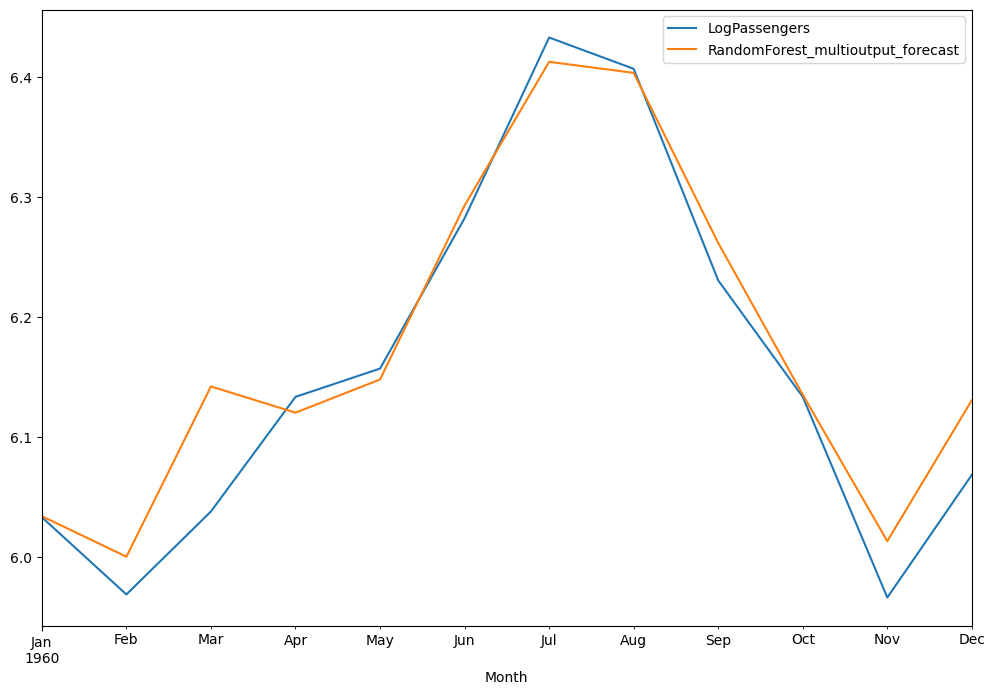

In [ ]:
multioutput_forecast(RandomForestRegressor(), 'RandomForest')

So as we can see the r2_score is very good for random forest and we can see from chart as well that the predictions are very close